# VAE on the real BACMMAN dataset

In [1]:
!pip install git+https://github.com/jeanollion/dataset_iterator.git
!pip install git+https://github.com/jeanollion/distnet.git
import tensorflow as tf
import h5py
import numpy as np
import matplotlib.pyplot as plt

# DRIVE
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive/BACMMAN_DISTNET/')

from uad.decision.reconstruction import is_anormal, decision_function, binarize_set
from uad.diagnostic.visualisation import plot_tSNE
from uad.diagnostic.metrics import compute_ROC, compute_AUC, plot_ROC

# copy data locallly
dataset_dir = f"/content/drive/My Drive/BACMMAN_DISTNET/data/BACMMAN/"
!cp "/content/drive/My Drive/BACMMAN_DISTNET/data/BACMMAN/train_val_eval.h5" "/home/train_val_eval.h5"
dataset_path = "/home/train_val_eval.h5"
print(dataset_path)

!nvidia-smi

  Cloning https://github.com/jeanollion/dataset_iterator.git to /tmp/pip-req-build-j39i6na5
  Running command git clone -q https://github.com/jeanollion/dataset_iterator.git /tmp/pip-req-build-j39i6na5
  Created wheel for dataset-iterator: filename=dataset_iterator-0.0.1-cp36-none-any.whl size=35945 sha256=c90fe84998bd80a14eca02f51b61a440941a32618716db03b468228a1a8f1f44
  Stored in directory: /tmp/pip-ephem-wheel-cache-zpi03nna/wheels/e1/b1/4a/efb8888afaa53e058db8520c203e13af93ca10b2a8d42ab098
Successfully built dataset-iterator
  Cloning https://github.com/jeanollion/distnet.git to /tmp/pip-req-build-u_tls2jj
  Running command git clone -q https://github.com/jeanollion/distnet.git /tmp/pip-req-build-u_tls2jj
  Created wheel for distnet: filename=distnet-0.0.1-cp36-none-any.whl size=51344 sha256=835e80b31a24ae78449e4c13e887ca939cd5bb6445e3526418494cf2445cd75f
  Stored in directory: /tmp/pip-ephem-wheel-cache-oqjpk982/wheels/12/6e/51/1b4851b9716ec2b0d0db57e350ee2eea8d95cb244578fea6f8
Su

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


/home/train_val_eval.h5
Sun Aug  2 18:48:13 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                

## Load datasets

In [2]:
# concatenate evaluation sets (norm only and anormal only) into a single h5
# file --> more convenient to load them into a single iterator after

from dataset_iterator import MultiChannelIterator, PreProcessingImageGenerator

eval_set_path = "/home/eval_set.h5"

# evaluation set, nominal and anormal classes ()
x_test_norm = MultiChannelIterator(dataset=dataset_path, 
                                channel_keywords=["/raw"],
                                group_keyword = "eval_norm",
                                input_channels=[0],
                                output_channels=[0], 
                                batch_size=64
                                )

x_test_anorm = MultiChannelIterator(dataset=dataset_path, 
                                channel_keywords=["/raw"],
                                group_keyword = "eval_anom",
                                input_channels=[0],
                                output_channels=[0], 
                                batch_size=64
                                )


def get_images(iterator):
    images = []
    for i in range(len(iterator)):
        bx, by = iterator[i]
        for im in bx:
            images.append(im)
    return np.array(images)

# get images
nominal_images = get_images(x_test_norm)
n_nominal = nominal_images.shape[0]
print(f"{n_nominal} nominal images")
anormal_images = get_images(x_test_anorm)
n_anormal = anormal_images.shape[0]
print(f"{n_anormal} anormal images")

with h5py.File(eval_set_path, 'w') as out_file:
    out_file.create_dataset("eval/0/raw", data=get_images(x_test_norm))
    out_file.create_dataset("eval/0/labels", data=np.zeros(n_nominal))
    out_file.create_dataset("eval/1/raw", data=get_images(x_test_anorm))
    out_file.create_dataset("eval/1/labels", data=np.array([1 for i in range(n_anormal)]))

851 nominal images
1011 anormal images


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from distnet.utils.pre_processing import random_scaling

corruption_function = lambda im: im + np.random.uniform(0, 1, im.shape) 
image_scaling = PreProcessingImageGenerator(lambda im:im/255.) 

def global_contrast_normalization(im, s=1, lmda=1, epsilon=1e-9):
    mu = np.mean(im)
    im = im - mu
    contrast = np.sqrt(lmda + np.mean(im**2))
    im = s * im / max(contrast, epsilon)
    return im

data_gen_train = ImageDataGenerator(horizontal_flip=True,
                                vertical_flip=True,
                                height_shift_range=0.2,
                                channel_shift_range=0.2,
                                fill_mode="nearest",
                                preprocessing_function=random_scaling)

image_scaling = ImageDataGenerator(preprocessing_function=random_scaling)

def corruption_random_scaling(batch_by_channel):
    batch_by_channel[1] = np.copy(batch_by_channel[0]) # creating channel 1
    batch_by_channel[0] = corruption_function(batch_by_channel[0])  # corruption on channel 0 only
    # batch_by_channel[0], batch_by_channel[1] = random_scaling(batch_by_channel[0]), random_scaling(batch_by_channel[1])
    # batch_by_channel[0], batch_by_channel[1] = global_contrast_normalization(batch_by_channel[0]), global_contrast_normalization(batch_by_channel[1])


def put_nominal_labels(batch_by_channel):
    size = len(batch_by_channel[0])
    batch_by_channel[1] = np.zeros(size)


def put_anormal_labels(batch_by_channel):
    size = len(batch_by_channel[0])
    batch_by_channel[1] = np.ones(size)

# train set, interest class only ([augmentation + corruption, augmentation without corruption])
x_train = MultiChannelIterator(dataset=dataset_path, 
                                channel_keywords=["/raw", None],
                                group_keyword = "train", 
                                input_channels=[0],
                                output_channels=[1], 
                                image_data_generators=[data_gen_train, None],
                                channels_postprocessing_function=corruption_random_scaling,
                                batch_size=100
                                )

# validation set, interest class only ([augmentation without corruption])
x_val = MultiChannelIterator(dataset=dataset_path, 
                                channel_keywords=["/raw"],
                                group_keyword = "val",
                                input_channels=[0],
                                output_channels=[0], 
                                image_data_generators=[data_gen_train],
                                batch_size=100
                                )

# evaluation set, nominal and anormal classes ()
x_test = MultiChannelIterator(dataset=eval_set_path, 
                                channel_keywords=["/raw", "/labels"],
                                group_keyword = ["eval/{}/".format(lab) for lab in range(2)],
                                input_channels=[0],
                                output_channels=[0, 1], 
                                image_data_generators=[image_scaling, None],
                                batch_size=64
                                )

print(f"Number of batches {len(x_train)} of size {len(x_train[0][0])}")

Number of batches 100 of size 100


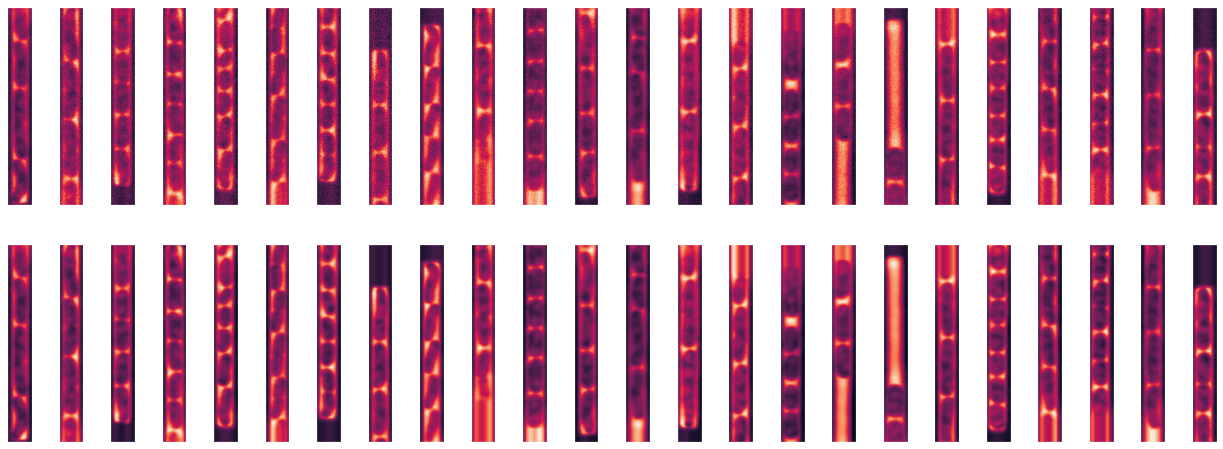

In [5]:
def plot_small_batches(n_batches=6, n=4, labx=None, laby=None):
    fig, axes = plt.subplots(2, n_batches * n, figsize=(22, 8), sharex="all", sharey="all")
    for batch in range(n_batches):
        bx, by = x_train[batch]
        for i in range(n):
            axes[0][i + batch * n].imshow(bx[i].squeeze(-1))
            axes[1][i + batch * n].imshow(by[i].squeeze(-1))
            axes[0][i + batch * n].get_xaxis().set_visible(False)
            axes[1][i + batch * n].get_yaxis().set_visible(False)
            axes[0][i + batch * n].get_xaxis().set_ticks([])
            axes[1][i + batch * n].get_yaxis().set_ticks([])

plot_small_batches()

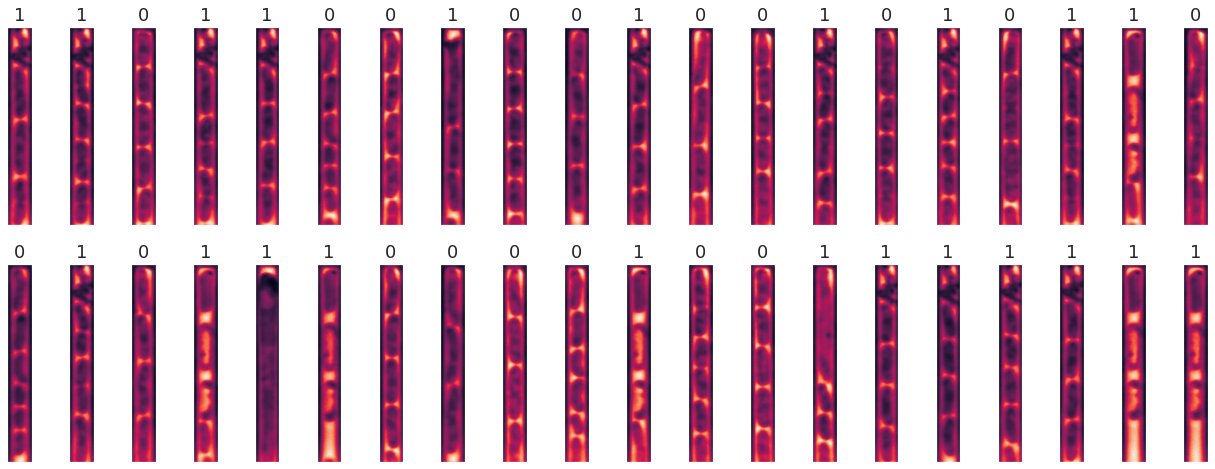

In [6]:
# check if the labels in x_test correspond to the images

def plot_images(bx, labs, n_ims=20):
    fig, axes = plt.subplots(2, (n_ims + 1) // 2, figsize=(22, 8), sharex="all", sharey="all")

    for i, ax in enumerate(axes.flatten()):
        ax.imshow(bx[i].squeeze(-1))
        ax.set_title(int(labs[i]))
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

bx, (by, labsy) = x_test[0]
plot_images(by, labsy, n_ims=40)

## Build model

In [7]:
from uad.models.architecture import get_unet_vae, get_ruff_vae
from uad.models.variational_autoencoder import Sampling
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2

n_filters = 32
n_contractions = 3
input_dims = (256, 32, 1)
latent_depth = n_filters * int(2**n_contractions)
latent_dims = (int(256 / (2**n_contractions)), int(32 / (2**n_contractions)), latent_depth)
batchnorm, dropout, spatial_dropout = False, 0, 0.2
activation_function = "linear"
k_size = (3, 1)

# encoder, decoder = get_unet_vae(n_filters=n_filters, n_contractions=n_contractions,
#                                 input_dims=input_dims, k_size=k_size, batchnorm=batchnorm,
#                                 dropout=dropout, spatial_dropout=spatial_dropout,
#                                 activation_function=activation_function, latent_depth=latent_depth)

def get_ruff_vae(input_dims=(32, 32, 3), n_filters=(32, 64, 128), k_size=(5, 5), LAMBDA=1e-6,
                 spatial_dropout=0.2, dropout=0, batchnorm=False):
    """
    LeNet-type architecture descirbed by Ruff et al. in their publication
    :param input_dims:
    :param n_filters:
    :param dense_sizes:
    :param k_size:
    :param LAMBDA:
    :param spatial_dropout:
    :param dropout:
    :param batchnorm:
    :return:
    """
    inputs = tf.keras.Input(shape=input_dims)

    # contraction
    n_contractions = len(n_filters)
    for i in range(n_contractions):
        if i == 0:
            x = layers.Conv2D(filters=n_filters[i], kernel_size=k_size, strides=(1, 1), kernel_regularizer=l2(LAMBDA),
                              padding="same", name=f"conv_1")(inputs)
        else:
            x = layers.Conv2D(filters=n_filters[i], kernel_size=k_size, strides=(1, 1), kernel_regularizer=l2(LAMBDA),
                              padding="same")(x)
        if spatial_dropout != 0:
            x = layers.SpatialDropout2D(spatial_dropout)(x)
        if dropout != 0:
            x = layers.Dropout(dropout)(x)
        if batchnorm:
            x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(alpha=0.1)(x)
        x = layers.MaxPooling2D((2, 2))(x)

    latent_depth = n_filters[0] * int(2 ** n_contractions)
    latent_dims = (int(input_dims[0] / (2 ** n_contractions)), int(input_dims[1] / (2 ** n_contractions)), latent_depth)

    z_mean = layers.Conv2D(latent_depth, 1, strides=1, name="z_mean")(x)
    z_log_var = layers.Conv2D(latent_depth, 1, strides=1, name="z_log_var")(x)
    z = Sampling()((z_mean, z_log_var))

    encoder = Model(inputs, [z_mean, z_log_var, z], name="encoder")

    # expansion
    latent_inputs = tf.keras.Input(shape=latent_dims)

    for i in range(n_contractions - 1, -1, -1):
        if i == n_contractions - 1:
            x = layers.Conv2DTranspose(n_filters[i], kernel_size=k_size, strides=(2, 2))(latent_inputs)
        else:
            x = layers.Conv2DTranspose(n_filters[i], kernel_size=k_size, strides=(2, 2))(x)
        x = layers.Conv2D(filters=n_filters[i], kernel_size=k_size, strides=(1, 1), kernel_regularizer=l2(LAMBDA),
                          padding="same")(x)
        x = layers.LeakyReLU(alpha=0.1)(x)
        if spatial_dropout != 0:
            x = layers.SpatialDropout2D(spatial_dropout)(x)
        if dropout != 0:
            x = layers.Dropout(dropout)(x)
        if batchnorm:
            x = layers.BatchNormalization()(x)

    x = layers.Conv2D(filters=input_dims[-1], kernel_size=k_size, strides=(1, 1), kernel_regularizer=l2(LAMBDA),
                      padding="same")(x)

    x = tf.keras.layers.Cropping2D(cropping=((4, 3), (0, 0)))(x)

    decoder = Model(latent_inputs, x, name="encoder")

    return encoder, decoder


encoder, decoder = get_ruff_vae(input_dims=input_dims, n_filters=(128, 256, 512),
                                k_size=(3, 1), LAMBDA=0, dropout=0.2)

print(encoder.summary(), decoder.summary())

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 32, 1)] 0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 256, 32, 128) 512         input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout2d (SpatialDropo (None, 256, 32, 128) 0           conv_1[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 32, 128) 0           spatial_dropout2d[0][0]          
____________________________________________________________________________________________

In [9]:
from uad.models.variational_autoencoder import VAE

vae = VAE(encoder, decoder, dims=(256, 32, 1), reconstruction_loss="mse", BETA=1e-6)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)

vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule))

In [ ]:
epochs = 100
batch_size = 4

import datetime, os
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

history = vae.fit(x_train, validation_data=x_val, epochs=epochs, callbacks=[tensorboard_callback])

Epoch 1/100
 16/100 [===>..........................] - ETA: 2:03 - loss: 1214.0777 - reconstruction_loss: 1214.0777 - kl_loss: 0.0132

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

In [ ]:
import os
os.chdir("/content/drive/My Drive/BACMMAN_DISTNET/models/")
tf.keras.models.save_model(vae, "vae_UNet_BACT")

In [ ]:
import os
os.chdir("/content/drive/My Drive/BACMMAN_DISTNET/models/")
tf.keras.models.load_model(vae, "vae_UNet_BACT")

In [ ]:
z_means, zlv, _ = vae.encoder.predict(x_test)
predictions = vae.predict(x_test)

## Plot images and reconstructions

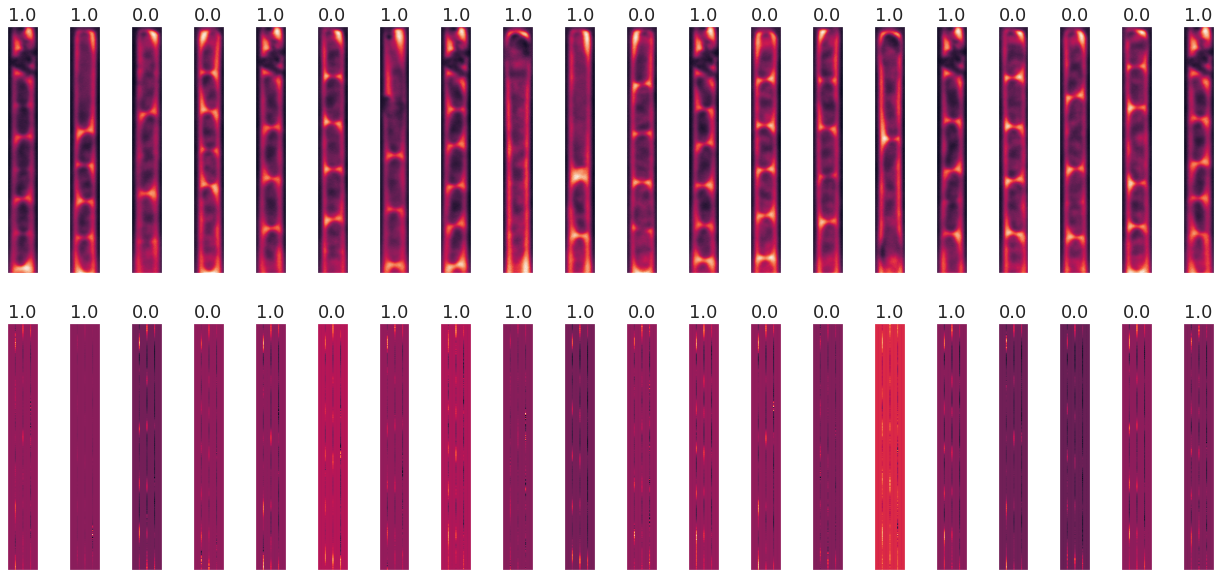

In [11]:
def plot_images_reconstructions(model, iterator, n_images=15, batch_size=4):

    fig, axes = plt.subplots(2, n_images, figsize=(22, 10), sharex="all", sharey="all")

    concerned_batches = (n_images + 1) //  batch_size
    predictions = []
    for k in range(concerned_batches):
        pred = model.predict(iterator[concerned_batches])
        predictions.append(pred)

    for i in range(n_images):
        batch = i // (batch_size)
        imx, (imy, laby) = iterator[batch]
        axes[0][i].imshow(imy[i % batch_size].squeeze(-1))
        axes[0][i].set_title(laby[i % batch_size])
        axes[1][i].imshow(predictions[batch][i % batch_size].squeeze(-1))
        axes[1][i].set_title(laby[i % batch_size])
        axes[0][i].get_xaxis().set_visible(False)
        axes[1][i].get_yaxis().set_visible(False)
        axes[0][i].get_xaxis().set_ticks([])
        axes[1][i].get_yaxis().set_ticks([])

plot_images_reconstructions(vae, x_test, n_images=20, batch_size=4)    